In [3]:
# importamos las librerías necesarias
%matplotlib inline
import random
import tsfresh
import os
import math
from scipy import stats
from scipy.spatial.distance import pdist
from math import sqrt, log, floor
from fastdtw import fastdtw
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mean
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance

sns.set(style='white')
# "fix" the randomness for reproducibility
random.seed(42)

### Dataset

Los datos son series temporales (casos semanales de Dengue) de distintos distritos de Paraguay

In [ ]:
path = "./data/Notificaciones/"
filename_read = os.path.join(path,"normalizado.csv")
notificaciones = pd.read_csv(filename_read,delimiter=",",engine='python')
notificaciones.shape

In [ ]:
listaMunicp = notificaciones['distrito_nombre'].tolist()
listaMunicp = list(dict.fromkeys(listaMunicp))
print('Son ', len(listaMunicp), ' distritos')
listaMunicp.sort()
print(listaMunicp)

A continuación tomamos las series temporales que leímos y vemos como quedan

In [ ]:
timeSeries = pd.DataFrame()
for muni in listaMunicp:
    municipio=notificaciones['distrito_nombre']==muni
    notif_x_municp=notificaciones[municipio]
    notif_x_municp = notif_x_municp.reset_index(drop=True)
    notif_x_municp = notif_x_municp['incidencia']
    notif_x_municp = notif_x_municp.replace('nan', np.nan).fillna(0.000001)
    notif_x_municp = notif_x_municp.replace([np.inf, -np.inf], np.nan).fillna(0.000001)
    timeSeries = timeSeries.append(notif_x_municp)
    ax = sns.tsplot(ax=None, data=notif_x_municp.values, err_style="unit_traces")
plt.show()

In [ ]:
#timeseries shape
n=217

In [ ]:
timeSeries.shape

In [ ]:
timeSeries.describe()

### Análisis de grupos (Clustering)

El Clustering o la clusterización es un proceso importante dentro del Machine learning. Este proceso desarrolla una acción fundamental que le permite a los algoritmos de aprendizaje automatizado entrenar y conocer de forma adecuada los datos con los que desarrollan sus actividades. Tiene como finalidad principal lograr el agrupamiento de conjuntos de objetos no etiquetados, para lograr construir subconjuntos de datos conocidos como Clusters. Cada cluster dentro de un grafo está formado por una colección de objetos o datos que a términos de análisis resultan similares entre si, pero que poseen elementos diferenciales con respecto a otros objetos pertenecientes al conjunto de datos y que pueden conformar un cluster independiente.

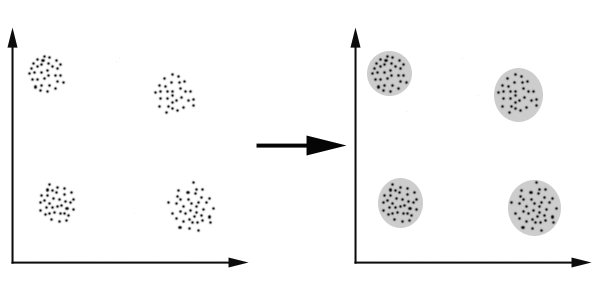

Aunque los datos no necesariamente son tan fáciles de agrupar

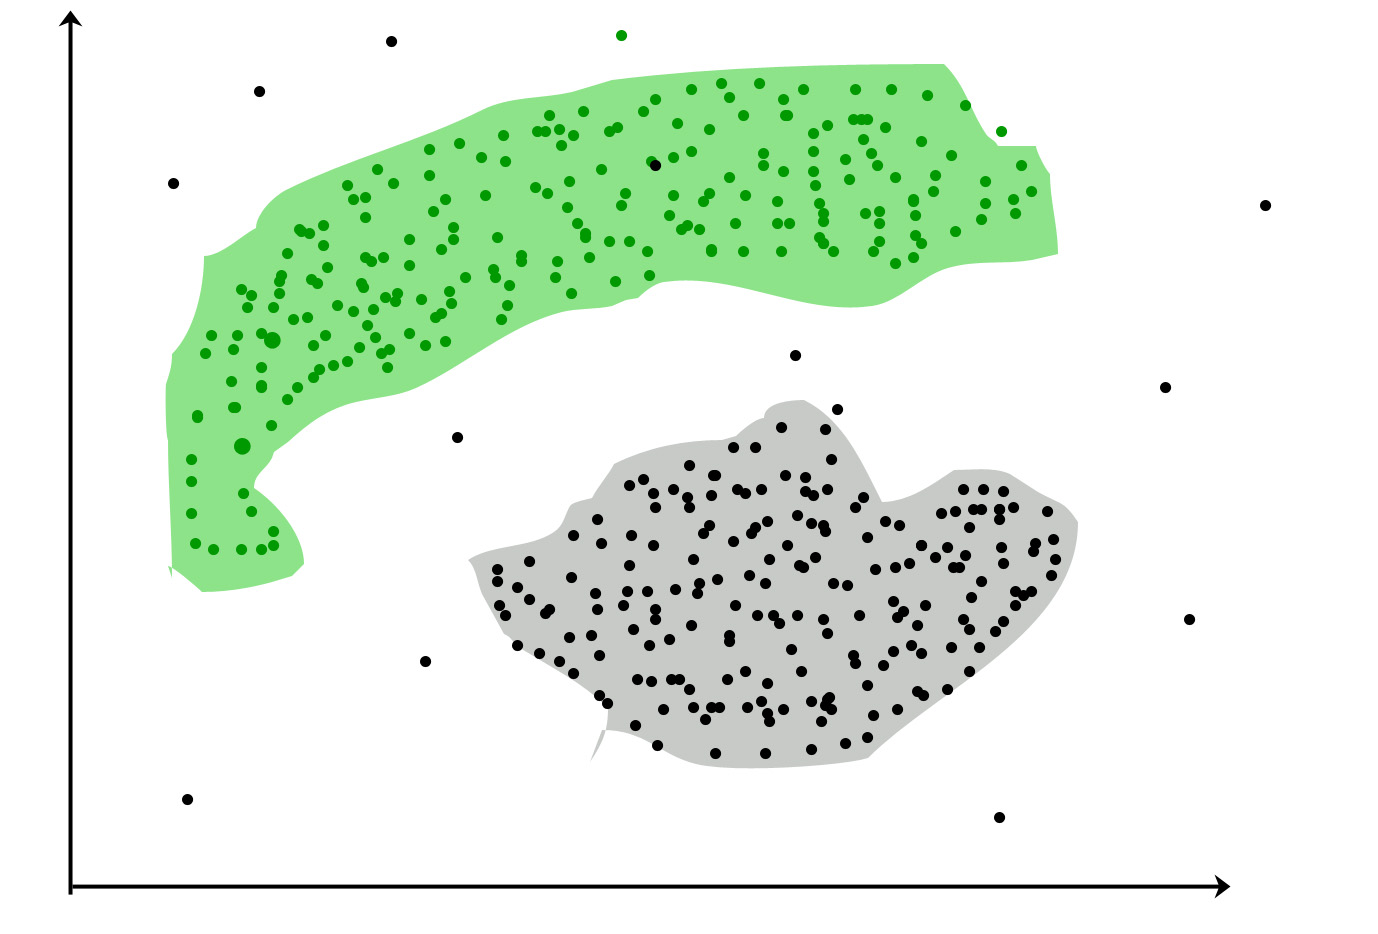

### Métricas de similitud

  Para medir lo similares ( o disimilares) que son los individuos existe una enorme cantidad de índices de similaridad y de disimilaridad o divergencia. Todos ellos tienen propiedades y utilidades distintas y habrá que ser consciente de ellas para su correcta aplicación al caso que nos ocupe.
La mayor parte de estos índices serán o bien, indicadores basados en la distancia (considerando a los individuos como vectores en el espacio de las variables) (en este sentido un elevado valor de la distancia entre dos individuos nos indicará un alto grado de disimilaridad entre ellos); o bien, indicadores basados en coeficientes de correlación ; o bien basados en tablas de datos de posesión o no de una serie de atributos. 
A continuación mostramos las funciones de: 
* Distancia Euclidiana
* Error cuadrático medio
* Fast Dynamic Time Warping
* Correlación de Pearson y
* Correlación de Spearman.

Existen muchas otras métricas y depende de la naturaleza de cada problema decidir cuál usar. Por ejemplo, *Fast Dymanic Time Warping* es una medida de similitud diseña especialmente para series temporales.


In [ ]:
#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

In [ ]:
#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

In [ ]:
#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

In [ ]:
#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [ ]:
#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [ ]:
# compute distances using LCSS

# function for LCSS computation
# based on implementation from
# https://rosettacode.org/wiki/Longest_common_subsequence
def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

In [ ]:
#Distancias para kmeans
#Euclidean
euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        euclidean_dist[i,j] = euclidean(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())
#RMSE
rmse_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        rmse_dist[i,j] = rmse(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())
#Corr
corr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        corr_dist[i,j] = corr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())
#scorr
scorr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        scorr_dist[i,j] = scorr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())
#DTW
dtw_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        dtw_dist[i,j] = fast_DTW(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

### Determinar el número de clusters a formar

La mayoría de las técnicas de clustering necesitan como *input* el número de clusters a formar, para eso lo que se hace es hacer una prueba con diferentes números de cluster y nos quedamos con el que dió menor error en general. Para medir ese error utilizamos **Silhouette score**.

El **Silhoutte score** se puede utilizar para estudiar la distancia de separación entre los clusters resultantes, especialmente si no hay conocimiento previo de cuáles son los verdaderos grupos para cada objeto, que es el caso más común en aplicaciones reales.

El Silhouette score $s(i)$ se calcula:
\begin{equation}
s(i)=\dfrac{b(i)-a(i)}{max(b(i),a(i))}   
\end{equation}

Definamos $a (i)$ como la distancia media del punto $(i)$ a todos los demás puntos del grupo que se le asignó ($A$). Podemos interpretar $a (i)$ como qué tan bien se asigna el punto al grupo. Cuanto menor sea el valor, mejor será la asignación.
De manera similar, definamos $b (i)$ como la distancia media del punto $(i)$ a otros puntos de su grupo vecino más cercano ($B$). El grupo ($B$) es el grupo al que no se asigna el punto $(i)$ pero su distancia es la más cercana entre todos los demás grupos. $ s (i) $ se encuentra en el rango de [-1,1].

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(3,20),metric='distortion', timings=False)

visualizer.fit(rmse_dist)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Así tenemos que son 9 los grupos que formaremos

In [ ]:
k=9

## Técnicas de clustering

### K-means

 El objetivo de este algoritmo es el de encontrar “K” grupos (clusters) entre los datos crudos. El algoritmo trabaja iterativamente para asignar a cada “punto” (las filas de nuestro conjunto de entrada forman una coordenada) uno de los “K” grupos basado en sus características. Son agrupados en base a la similitud de sus features (las columnas). Como resultado de ejecutar el algoritmo tendremos:

* Los “centroids” de cada grupo que serán unas “coordenadas” de cada uno de los K conjuntos que se utilizarán para poder etiquetar nuevas muestras.
* Etiquetas para el conjunto de datos de entrenamiento. Cada etiqueta perteneciente a uno de los K grupos formados.

Los grupos se van definiendo de manera “orgánica”, es decir que se va ajustando su posición en cada iteración del proceso, hasta que converge el algoritmo. Una vez hallados los centroids deberemos analizarlos para ver cuales son sus características únicas, frente a la de los otros grupos. 

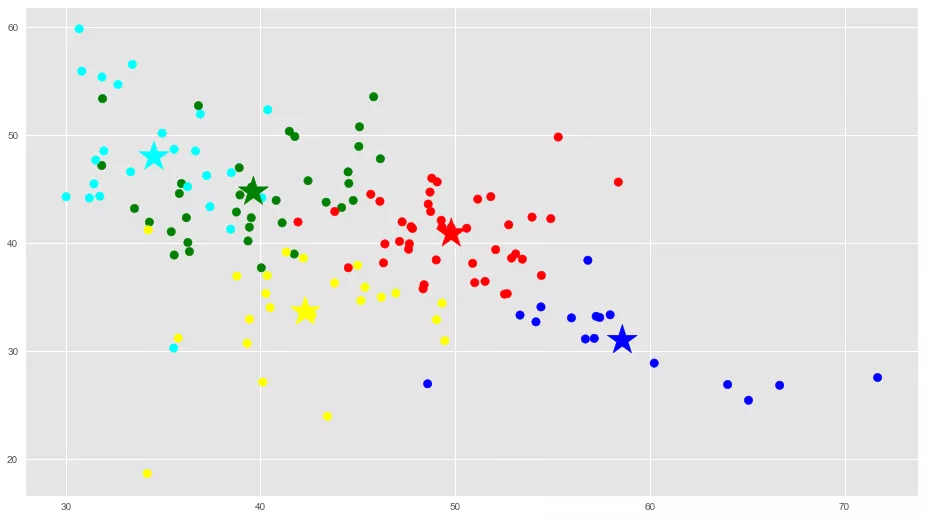

En la figura de arriba vemos como los datos se agrupan según el *centroid* que está representado por una estrella. El algortimo inicializa los centroides aleatoriamente y va ajustandolo en cada iteracción, los puntos que están más cerca del *centroid* son los que pertenecen al mismo grupo. 

### Clustering jerárquico

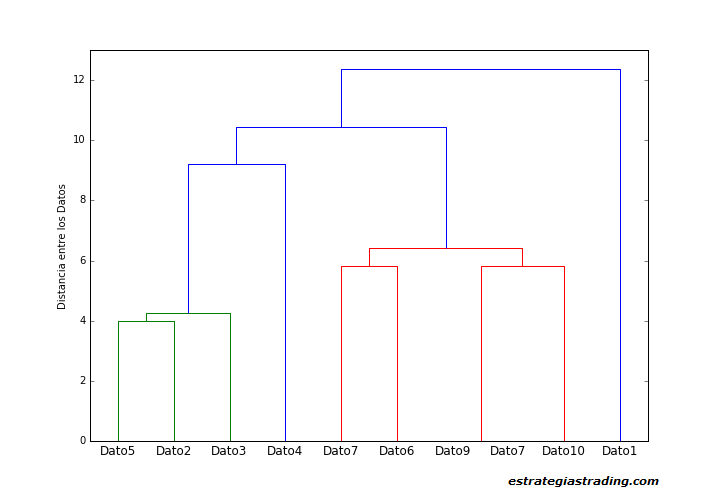

El algortimo de clúster jerárquico agrupa los datos basándose en la distancia entre cada uno y buscando que los datos que están dentro de un clúster sean los más similares entre sí.

En una representación gráfica los elementos quedan anidados en jerarquías con forma de árbol. 

### DBScan

El agrupamiento espacial basado en densidad de aplicaciones con ruido o Density-based spatial clustering of applications with noise (DBSCAN) es un algoritmo de agrupamiento de datos (data clustering). Es un algoritmo de agrupamiento basado en densidad (density-based clustering) porque encuentra un número de grupos (clusters) comenzando por una estimación de la distribución de densidad de los nodos correspondientes. DBSCAN es uno de los algoritmos de agrupamiento más usados y citados en la literatura científica.

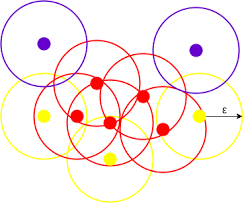

Los puntos marcados en rojo son puntos núcleo. Los puntos amarillos son densamente alcanzables desde rojo y densamente conectados con rojo, y pertenecen al mismo clúster. El punto azul es un punto ruidoso que no es núcleo ni densamente alcanzable.

In [ ]:
#Experimentos
print('Silhouette coefficent')
#HAC + euclidean
Z = hac.linkage(timeSeries,  method='complete', metric=euclidean)
clusters = fcluster(Z, k, criterion='maxclust')
print("HAC + euclidean distance: ",silhouette_score(euclidean_dist, clusters))
#HAC + rmse
Z = hac.linkage(timeSeries,  method='complete', metric=rmse)
clusters = fcluster(Z, k, criterion='maxclust')
print("HAC + rmse distance: ",silhouette_score( rmse_dist, clusters))
#HAC + corr
Z = hac.linkage(timeSeries,  method='complete', metric=corr)
clusters = fcluster(Z, k, criterion='maxclust')
print("HAC + corr distance: ",silhouette_score( corr_dist, clusters))
#HAC + scorr
Z = hac.linkage(timeSeries,  method='complete', metric=scorr)
clusters = fcluster(Z, k, criterion='maxclust')
print("HAC + scorr distance: ",silhouette_score( scorr_dist, clusters))
#HAC + LCSS
#Z = hac.linkage(timeSeries,  method='complete', metric=multidim_lcs)
#clusters = fcluster(Z, k, criterion='maxclust')
#print("HAC + LCSS distance: ",silhouette_score( timeSeries, clusters, metric=multidim_lcs))
#HAC + DTW
Z = hac.linkage(timeSeries,  method='complete', metric=fast_DTW)
clusters = fcluster(Z, k, criterion='maxclust')
print("HAC + DTW distance: ",silhouette_score( dtw_dist, clusters))

In [ ]:
km_euc = KMeans(n_clusters=k).fit_predict(euclidean_dist)
silhouette_avg=silhouette_score( euclidean_dist, km_euc)
print("KM + euclidian distance: ",silhouette_score( euclidean_dist, km_euc))
km_rmse = KMeans(n_clusters=k).fit_predict(rmse_dist)
print("KM + rmse distance: ",silhouette_score( rmse_dist, km_rmse))
km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ",silhouette_score( corr_dist, km_corr))
km_scorr = KMeans(n_clusters=k).fit_predict(scorr_dist)
print("KM + scorr distance: ",silhouette_score( scorr_dist, km_scorr))
km_dtw = KMeans(n_clusters=k).fit_predict(dtw_dist)
print("KM + dtw distance: ",silhouette_score( dtw_dist, clusters))

In [ ]:
#Experimentos DBSCAN
DB_euc = DBSCAN(eps=3, min_samples=2).fit_predict(euclidean_dist)
silhouette_avg=silhouette_score( euclidean_dist, DB_euc)
print("DBSCAN + euclidian distance: ",silhouette_score( euclidean_dist, DB_euc))
DB_rmse = DBSCAN(eps=12, min_samples=10).fit_predict(rmse_dist)
#print("DBSCAN + rmse distance: ",silhouette_score( rmse_dist, DB_rmse))
print("DBSCAN + rmse distance: ",0.00000000)
DB_corr = DBSCAN(eps=3, min_samples=2).fit_predict(corr_dist)
print("DBSCAN + corr distance: ",silhouette_score( corr_dist, DB_corr))
DB_scorr = DBSCAN(eps=3, min_samples=2).fit_predict(scorr_dist)
print("DBSCAN + scorr distance: ",silhouette_score( scorr_dist, DB_scorr))
DB_dtw = DBSCAN(eps=3, min_samples=2).fit_predict(dtw_dist)
print("KM + dtw distance: ",silhouette_score( dtw_dist, DB_dtw))

## Clustering basado en propiedades

Otro enfoque en el clustering es extraer ciertas propiedades de nuestros datos y hacer la agrupación basándonos en eso, el procedimiento es igual a como si estuviesemos trabajando con nuestros datos reales.

In [ ]:
from tsfresh import extract_features

#features extraction
extracted_features = extract_features(timeSeries, column_id="indice")

In [ ]:
extracted_features.shape

In [ ]:
list(extracted_features.columns.values)

In [ ]:
n=217
features = pd.DataFrame()
Mean=[]
Var=[]
aCF1=[]
Peak=[]
Entropy=[]
Cpoints=[]
for muni in listaMunicp:
    municipio=notificaciones['distrito_nombre']==muni
    notif_x_municp=notificaciones[municipio]
    notif_x_municp = notif_x_municp.reset_index(drop=True)
    notif_x_municp = notif_x_municp['incidencia']
    notif_x_municp = notif_x_municp.replace('nan', np.nan).fillna(0.000001)
    notif_x_municp = notif_x_municp.replace([np.inf, -np.inf], np.nan).fillna(0.000001)
    #Features
    mean=tsfresh.feature_extraction.feature_calculators.mean(notif_x_municp)
    var=tsfresh.feature_extraction.feature_calculators.variance(notif_x_municp)
    ACF1=tsfresh.feature_extraction.feature_calculators.autocorrelation(notif_x_municp,1)
    peak=tsfresh.feature_extraction.feature_calculators.number_peaks(notif_x_municp,20)
    entropy=tsfresh.feature_extraction.feature_calculators.sample_entropy(notif_x_municp)
    cpoints=tsfresh.feature_extraction.feature_calculators.number_crossing_m(notif_x_municp,5)
    Mean.append(mean)
    Var.append(var)
    aCF1.append(ACF1)
    Peak.append(peak)
    Entropy.append(entropy)
    Cpoints.append(cpoints)

In [ ]:
data_tuples = list(zip(Mean,Var,aCF1,Peak,Entropy,Cpoints))
features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1', 'Peak','Entropy','Cpoints']) 
# print the data 
features

In [ ]:
features.iloc[1]

In [ ]:
#Distancias para kmeans
#Euclidean
f_euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
        #print("j",j)
        f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#RMSE
f_rmse_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        f_rmse_dist[i,j] = rmse(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#Corr
#print(features.iloc[i].values.flatten())
#print(features.iloc[j].values.flatten())
print('-------------------------------')
f_corr_dist = np.zeros((n,n))
#for i in range(0,n):
   # print("i",i)
 #   for j in range(0,n):
  #      print("j",j)
    #    print(features.iloc[i].values.flatten())
     #   print(features.iloc[j].values.flatten())
      #  f_corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#scorr
f_scorr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(3,50),metric='distortion', timings=False)

visualizer.fit(f_scorr_dist)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
k=9

In [ ]:
km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
silhouette_avg=silhouette_score( f_euclidean_dist, km_euc)
print("KM + euclidian distance: ",silhouette_score( f_euclidean_dist, km_euc))
km_rmse = KMeans(n_clusters=k).fit_predict(f_rmse_dist)
print("KM + rmse distance: ",silhouette_score( f_rmse_dist, km_rmse))
#km_corr = KMeans(n_clusters=k).fit_predict(f_corr_dist)
#print("KM + corr distance: ",silhouette_score( f_corr_dist, km_corr))
#print("KM + corr distance: ",silhouette_score( f_corr_dist, 0.0))
km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
print("KM + scorr distance: ",silhouette_score( f_scorr_dist, km_scorr))
km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
print("KM + dtw distance: ",silhouette_score( f_dtw_dist, clusters))

In [ ]:
#Experimentos HAC
HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(f_euclidean_dist)
silhouette_avg=silhouette_score( f_euclidean_dist, HAC_euc)
print("HAC + euclidian distance: ",silhouette_score( f_euclidean_dist, HAC_euc))
HAC_rmse = AgglomerativeClustering(n_clusters=k).fit_predict(f_rmse_dist)
print("HAC + rmse distance: ",silhouette_score( f_rmse_dist, HAC_rmse))
#HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(f_corr_dist)
#print("HAC + corr distance: ",silhouette_score( f_corr_dist,HAC_corr))
print("HAC + corr distance: ",0.0)
HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(f_scorr_dist)
print("HAC + scorr distance: ",silhouette_score( f_scorr_dist, HAC_scorr))
HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(f_dtw_dist)
print("HAC + dtw distance: ",silhouette_score( f_dtw_dist, HAC_dtw))

In [ ]:
#Experimentos DBSCAN
DB_euc = DBSCAN(eps=3, min_samples=2).fit_predict(f_euclidean_dist)
silhouette_avg=silhouette_score( f_euclidean_dist, DB_euc)
print("DBSCAN + euclidian distance: ",silhouette_score( f_euclidean_dist, DB_euc))
DB_rmse = DBSCAN(eps=12, min_samples=10).fit_predict(f_rmse_dist)
#print("DBSCAN + rmse distance: ",silhouette_score( f_rmse_dist, DB_rmse))
#print("DBSCAN + rmse distance: ",0.00000000)
#DB_corr = DBSCAN(eps=3, min_samples=2).fit_predict(f_corr_dist)
#print("DBSCAN + corr distance: ",silhouette_score( f_corr_dist, DB_corr))
print("DBSCAN + corr distance: ",0.0)
DB_scorr = DBSCAN(eps=3, min_samples=2).fit_predict(f_scorr_dist)
print("DBSCAN + scorr distance: ",silhouette_score( f_scorr_dist, DB_scorr))
DB_dtw = DBSCAN(eps=3, min_samples=2).fit_predict(f_dtw_dist)
print("KM + dtw distance: ",silhouette_score( f_dtw_dist, DB_dtw))